In [1]:
import numpy as np
import math
from scipy.integrate import quad
from scipy.linalg import eigvalsh
from scipy.optimize import minimize_scalar
from scipy.stats import linregress
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
#kronecker product code for more than 2 inputs
def kron(*matrices):
    result = np.array([[1]])
    for matrix in matrices:
        result = np.kron(result, matrix)
    return result

#Partial Trace Code
def IntegerDigits(n, b, l):
    digits = [0] * l
    pos = l - 1
    while pos != -1:
        digits[pos] = int(n % b)
        n //= b
        pos -= 1
    return digits

def FromDigits(digits, base):
    digits = digits[::-1]
    n = 0
    for i, d in enumerate(digits):
        n += d * base**i
        
    return n

def SwapParts(digits, p1, p2):
    new = np.copy(digits)
    new[p1] = digits[p2]
    new[p2] = digits[p1]
    return new

def dTraceSystem(D,s,dimen):
    Qudits=sorted(s)
    Qudits.reverse()
    TrkM = D
    z=len(Qudits)
    
    for q in range(z):
        n=math.log(TrkM.shape[0],dimen)
        assert n % 1 == 0
        n = int(n)
        
        M=TrkM
        M = np.array(M , dtype = complex)
        k=Qudits[q]
        temp = np.zeros(M.shape[0], dtype=complex)
        if k!=n:
            for j in range(n-k):
                b={0}
                for i in range(dimen**n):
                    digits=IntegerDigits(i,dimen,n)
                    if digits[n-1] != digits[n-j-2] and i not in  b:
                        number=FromDigits(
                            SwapParts(digits, n-1, n-j-2),
                            dimen
                        )
                        b.add(number)

                        temp[:] = M[i, :]
                        M[i, :] = M[number, :]
                        M[number, :] = temp

                        temp[:] = M[:, i]
                        M[:, i] = M[:, number]
                        M[:, number] = temp
        
        TrkM=[]
        for p in range(0,dimen**n,dimen):
            TrkM.append(
                sum(
                    M[p+h, h:dimen**n:dimen]
                    for h in range(dimen)
                )
            )
        TrkM = np.array(TrkM)
    
    return TrkM
#Recall matrix as dTraceSystem(matrix,[systems I want to trace out],dimension of system)


In [3]:
#defining basis vectors

#zero vector and its conjugate transpose                                         
zero= np.array([[1],[0]])
zeroCT=np.conjugate(zero.T)
#one vector and its conjugate transpose
one=np.array([[0],[1]])
oneCT=np.conjugate(one.T)
#plus vector and its conjugate transpose
plus=np.array([[1],[1]])*1/math.sqrt(2)
plusCT=np.conjugate(plus.T)
#minus vector and its conjugate transpose
minus=np.array([[1],[-1]])*1/math.sqrt(2)
minusCT=np.conjugate(minus.T)
#plusy and its conjugate transpose
plusy=np.array([[1],[complex(0.0, 1)]])*1/math.sqrt(2)
plusyCT=np.conjugate(plusy.T)
#minusy and its conjugate transpose
minusy=np.array([[1],[complex(0.0, -1)]])*1/math.sqrt(2)
minusyCT=np.conjugate(minusy.T)
#defining the Bell states
phiplus=(np.kron(zero, zero)+np.kron(one, one))*1/math.sqrt(2)
phiminus=(np.kron(zero, zero)-np.kron(one, one))*1/math.sqrt(2)
psiplus=(np.kron(zero, one)+np.kron(one, zero))*1/math.sqrt(2)
psiminus=(np.kron(zero, one)-np.kron(one, zero))*1/math.sqrt(2)
#defining the outer product of the Bell states
Phiplus=phiplus@np.conjugate(phiplus.T)
Phiminus=phiminus@np.conjugate(phiminus.T)
Psiplus=psiplus@np.conjugate(psiplus.T)
Psiminus=psiminus@np.conjugate(psiminus.T)
#defining Pauli matrices
pauliX=np.array([[0,1],[1,0]])
pauliY=np.array([[0,complex(0,-1)],[complex(0,1),0]])
pauliZ=np.array([[1,0],[0,-1]])

In [4]:
def r(p, q):
    return np.array([
        p[3]*q[0] + p[2]*q[1] + p[1]*q[2] + p[0]*q[3],
        p[2]*q[0] + p[3]*q[1] + p[0]*q[2] + p[1]*q[3],
        p[1]*q[0] + p[0]*q[1] + p[3]*q[2] + p[2]*q[3],
        p[0]*q[0] + p[1]*q[1] + p[2]*q[2] + p[3]*q[3]
    ])

def rNtimes(p, n):
    if n == 1:
        return r(p, p)
    else:
        return r(rNtimes(p, n-1), p)

In [5]:
#Defining parameters for GKP states


# transmissivity for QR setup
def new_eta(L, n):
    alpha_dB_per_km = 0.2
    alpha = (alpha_dB_per_km / 10) * np.log(10)  # convert dB/km to 1/km
    return np.exp(-alpha * L / (n + 1))  # eta ∈ [0, 1]

#Quality of GKP state
def sigmaloss(sigma , L , n):
    eta = new_eta(L , n)
    return np.sqrt(eta * sigma**2 + (1 - eta))


#Error functions
def f(x , mu , sigma , L , n):
    s = sigmaloss(sigma , L , n)
    return np.exp(-(x - mu)**2 / (2 * s**2))/(s * np.sqrt(2*np.pi))

def Pc(sigma , nu , L , n):
    integrand = lambda x: f(x , 0 , sigma , L , n)
    lower = -0.5 * np.sqrt(np.pi) + nu
    upper =  0.5 * np.sqrt(np.pi) - nu
    return quad(integrand, lower, upper)[0] 
    
def Pf(sigma , nu , L , n):
    integrand = lambda x: f(x, 0, sigma, L , n)
    lower = 0.5 * np.sqrt(np.pi) + nu
    upper = 1.5 * np.sqrt(np.pi) - nu
    return 2 * quad(integrand, lower, upper)[0]



#Bell state mixture probabilities


def p1(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pc**2) / (pc + pf)**2

def p2(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pc * pf) / (pc + pf)**2

def p3(sigma , nu , L , n):
    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)
    return (pf**2) / (pc + pf)**2



#Mixture of Bell states

def new_vector(sigma , nu , L , n):
    return np.array([
        p1(sigma , nu , L , n) , 
        p2(sigma , nu , L , n) , 
        p2(sigma , nu , L , n) , 
        p3(sigma , nu , L , n)
        ])


#von Neumann entropy

def vonneumann(mat):
    evals = eigvalsh(mat)
    evals = np.clip(evals, 1e-16 , 1)
    return -np.sum(evals * np.log2(evals))



# hashing bound

def hashing_bound(mat):
    sAB = vonneumann(mat)
    sA = vonneumann(dTraceSystem(mat , [2] , 2))
    sB = vonneumann(dTraceSystem(mat , [1] , 2))
    return max(sA - sAB , sB - sAB)



# chain function

def chain_function(vec , n):
    return rNtimes(vec , n)



# building the chain states

def BSM_mixture_chain(vec):
    return vec[0] * Phiplus + vec[1] * Phiminus + vec[2] * Psiplus + vec[3] * Psiminus
 

# defining the probability of success for repeaters

# BSM swaps are no longer deterministic
# we model realistic repeater architectures
# these architectures perform probabilistic entanglement generation
# we only succeed when ALL elementary links generate entangled pairs
# AND all BSM swaps succeed

# these probability of successes have been adjusted in each respectiv hashing rate definition

In [6]:
#GKP chains

# hashing rate
def hashing_rate(sigma , nu , L , n , M , q , tau , m):

    pc = Pc(sigma , nu , L , n)
    pf = Pf(sigma , nu , L , n)

    # probability of BSM swap
    pSWAP = (pc + pf)**2
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    vec = chain_function(new_vector(sigma , nu , L , n) , n)
    
    return rate * hashing_bound(BSM_mixture_chain(vec))


# optimal hashing rate
def optimal_hashing_rate(sigma , L , n , M , q , tau , m , return_nu = False):
    def neg_rate(nu):
        try:
            value = hashing_rate(sigma , nu , L , n , M , q , tau , m)
            return -value if value > 0 else np.inf
        except Exception:
            return np.inf

    result = minimize_scalar(neg_rate, bounds=(0, 0.5 * np.sqrt(np.pi)), method='bounded')
    rate = -result.fun

    if not np.isfinite(rate) or rate <= 0:
        rate = 0.0

    if return_nu:
        return rate , result.x  # return rate, ν
    return rate

In [7]:
# Single Rail

def SingleRailState(eta , gamma , Pd , Vis):
    return 2 * np.array(
        [
            [(1 - Pd)*Pd*gamma**2, 0 , 0 , 0], 
            [0 , (1 - Pd) * Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta)* Vis , 0] ,
            [0 , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) * Vis , (1 - Pd)* Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta), 0] ,
            [0 , 0 , 0, (1 - Pd) * Pd * ((1 - gamma)**2) * ((1 - np.sqrt(eta))**2) + ((1 - Pd)**2) * ((1 - gamma)**2) * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for single-rail entangled memory pair
def QStateSingle(eta , gamma , Pd , Vis):
    state = SingleRailState(eta , gamma , Pd , Vis)
    tr = np.trace(state)
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# Building chains of SR encoded states

def SRinitialState(eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho = kron(QStateSingle(eta , gamma , 0 , 1) , QStateSingle(eta , gamma , 0 , 1))
    rho = BSM @ rho @ np.conjugate(BSM.T)
    rho = rho / np.trace(rho)
    return dTraceSystem(rho , [2 , 3] , 2)

def SRextendState(rho , eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho_ext = kron(rho , QStateSingle(eta , gamma , 0 , 1))
    rho_ext = BSM @ rho_ext @ np.conjugate(BSM.T)
    rho_ext = rho_ext / np.trace(rho_ext)
    return dTraceSystem(rho_ext , [2 , 3] , 2)

def SRchainState(L , gamma , n):
    eta = new_eta(L , n)
    if n == 1:
        return QStateSingle(eta , gamma , 0 , 1)
    rho = SRinitialState(eta , gamma)
    for _ in range(n - 2):
        rho = SRextendState(rho , eta , gamma)
    return rho

# Single-Rail Hashing Rate
def SRhashingrate(L , gamma , n , M , q , tau , m):

    eta = new_eta(L , n)
    PsuccSR = np.trace(SingleRailState(eta , gamma , 0 , 1))

    # probability of BSM swap
    pSWAP = PsuccSR
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    rho = SRchainState(L , gamma , n)
    return rate * hashing_bound(rho)

# optimising over gamma
def optimal_SRhashingrate(L , n , M , q , tau , m):
    gammas = np.linspace(0, 1, 100)
    best_rate = 0.0
    best_gamma = None
    for gamma in gammas:
        try:
            rate = SRhashingrate(L , gamma, n , M , q , tau , m)
            # ensuring that the hashing rate is a valid number
            if not np.isnan(rate) and not np.isinf(rate):
                if rate > best_rate:
                    best_rate = rate
                    best_gamma = gamma
        except Exception as e:
            # print(f"Skipping gamma = {gamma}: {e}")
            continue
    return best_rate , best_gamma if best_gamma is not None else 0


In [8]:
# Dual Rail
def DualRailState(eta , Pd , Vis):
    return 4 * np.array(
        [
            [1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta), 0 , 0 , 0] ,
            [0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 1/16 * ((1 - Pd)**4) * eta * Vis**2 , 0] ,
            [0 , 1/16 * ((1 - Pd)**4) *eta * Vis**2 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 0] ,
            [0 , 0 , 0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for dual-rail entangled memory pair
def QStateDual(eta , Pd , Vis):
    state = DualRailState(eta , Pd , Vis)
    tr = np.trace(DualRailState(eta , Pd , Vis))
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# hashing rate
def DRhashingrate(L , n , M , q , tau , m):
    eta = new_eta(L , n)
    PsuccDR = np.trace(DualRailState(eta , 0 , 1))

    # probability of BSM swap
    pSWAP = PsuccDR
    # probability single element success
    pELEM = 1 - (1 - pSWAP)**(M * m)
    # probability successful connection between end users
    pNETWORK = pELEM**(n + 1) * q**n
    # achievable rate of entanglement generation for the network
    rate = pNETWORK / (tau * m)

    if n == 1:
        return rate * hashing_bound(QStateDual(eta , 0 , 1))
    else:
        vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta , 0 , 1)) , n - 1)
        rho = BSM_mixture_chain(vec)
        return rate * hashing_bound(rho)

In [9]:
def gkp_hashing_rate_list(sigma, Ls, n_vals, M, q, tau, m):
    return [
        [optimal_hashing_rate(sigma, L, n, M, q, tau, m) for L in Ls]
        for n in n_vals
    ]
def sr_hashing_rate_list(Ls, n_vals, M, q, tau, m):
    return [
        [optimal_SRhashingrate(L, n, M, q, tau, m)[0] for L in Ls]
        for n in n_vals
    ]
def dr_hashing_rate_list(Ls, n_vals, M, q, tau, m):
    return [
        [DRhashingrate(L, n, M, q, tau, m) for L in Ls]
        for n in n_vals
    ]

In [10]:
def compute_gkp_envelope_and_fit(sigma, Ls, n_scan_vals, M, q, tau, m, L_min=20, L_max=80):
    rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            _, nu_opt = optimal_hashing_rate(sigma, L, n, M, q, tau, m, return_nu=True)
            pc = Pc(sigma, nu_opt, L, n)
            pf = Pf(sigma, nu_opt, L, n)
            pSWAP = (pc + pf)**2
            pELEM = 1 - (1 - pSWAP)**(M * m)
            pNETWORK = pELEM**(n + 1) * q**n
            rate = pNETWORK / (tau * m)

            vec = chain_function(new_vector(sigma, nu_opt, L, n), n)
            state_bound = hashing_bound(BSM_mixture_chain(vec))

            true_hashing_rate = rate * state_bound
            best_rate = max(best_rate, true_hashing_rate)
        rate_envelope.append(best_rate)

    rate_env_arr = np.array(rate_envelope)
    valid_mask = (rate_env_arr > 0) & np.isfinite(rate_env_arr)
    fit_Ls = Ls[valid_mask]
    log_env = np.log(rate_env_arr[valid_mask])

    fit_mask = (fit_Ls > L_min) & (fit_Ls < L_max)
    slope, intercept, *_ = linregress(fit_Ls[fit_mask], log_env[fit_mask])
    predicted_env = np.exp(slope * Ls + intercept)

    return rate_env_arr, predicted_env

def compute_sr_envelope_and_fit(Ls, n_scan_vals, M, q, tau, m, L_min=20, L_max=80):
    rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            try:
                rate, _ = optimal_SRhashingrate(L, n, M, q, tau, m)
                best_rate = max(best_rate, rate)
            except:
                continue
        rate_envelope.append(best_rate)

    rate_env_arr = np.array(rate_envelope)
    valid_mask = (rate_env_arr > 0) & np.isfinite(rate_env_arr)
    fit_Ls = Ls[valid_mask]
    log_env = np.log(rate_env_arr[valid_mask])

    fit_mask = (fit_Ls > L_min) & (fit_Ls < L_max)
    slope, intercept, *_ = linregress(fit_Ls[fit_mask], log_env[fit_mask])
    predicted_env = np.exp(slope * Ls + intercept)

    return rate_env_arr, predicted_env

def compute_dr_envelope_and_fit(Ls, n_scan_vals, M, q, tau, m, L_min=20, L_max=80):
    rate_envelope = []
    for L in Ls:
        best_rate = 0
        for n in n_scan_vals:
            try:
                rate = DRhashingrate(L, n, M, q, tau, m)
                if np.isfinite(rate):
                    best_rate = max(best_rate, rate)
            except:
                continue
        rate_envelope.append(best_rate)

    rate_env_arr = np.array(rate_envelope)
    valid_mask = (rate_env_arr > 0) & np.isfinite(rate_env_arr)
    fit_Ls = Ls[valid_mask]
    log_env = np.log(rate_env_arr[valid_mask])

    fit_mask = (fit_Ls > L_min) & (fit_Ls < L_max)
    slope, intercept, *_ = linregress(fit_Ls[fit_mask], log_env[fit_mask])
    predicted_env = np.exp(slope * Ls + intercept)

    return rate_env_arr, predicted_env

In [19]:
gkp_envelopes = []
sr_envelopes = []
dr_envelopes = []
n_scan_vals = np.arange(1, 16)
Ls = np.arange(0, 300, 3)
sigma1 = np.sqrt(0.01)
q = 0.7
tau = 1e-8
M_vals = [1 , 2 , 3 , 50]
m_vals = [1 , 2 , 10 , 50]

gkp_envelope_data = {}
sr_envelope_data = {}
dr_envelope_data = {}

for M in M_vals:
    gkp_envelopes = []
    for m in m_vals:
        rate_env, predicted_env = compute_gkp_envelope_and_fit(
            sigma1, Ls, n_scan_vals, M=M, q=q, tau=tau, m=m
        )
        gkp_envelopes.append((m, predicted_env))
    gkp_envelope_data[M] = gkp_envelopes

for M in M_vals:
    sr_envelopes = []
    for m in m_vals:
        rate_env, predicted_env = compute_sr_envelope_and_fit(
            Ls, n_scan_vals, M=M, q=q, tau=tau, m=m
        )
        sr_envelopes.append((m, predicted_env))
    sr_envelope_data[M] = sr_envelopes

for M in M_vals:
    dr_envelopes = []
    for m in m_vals:
        rate_env, predicted_env = compute_dr_envelope_and_fit(
            Ls, n_scan_vals, M=M, q=q, tau=tau, m=m
        )
        dr_envelopes.append((m, predicted_env))
    dr_envelope_data[M] = dr_envelopes

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_43089/1773137400.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


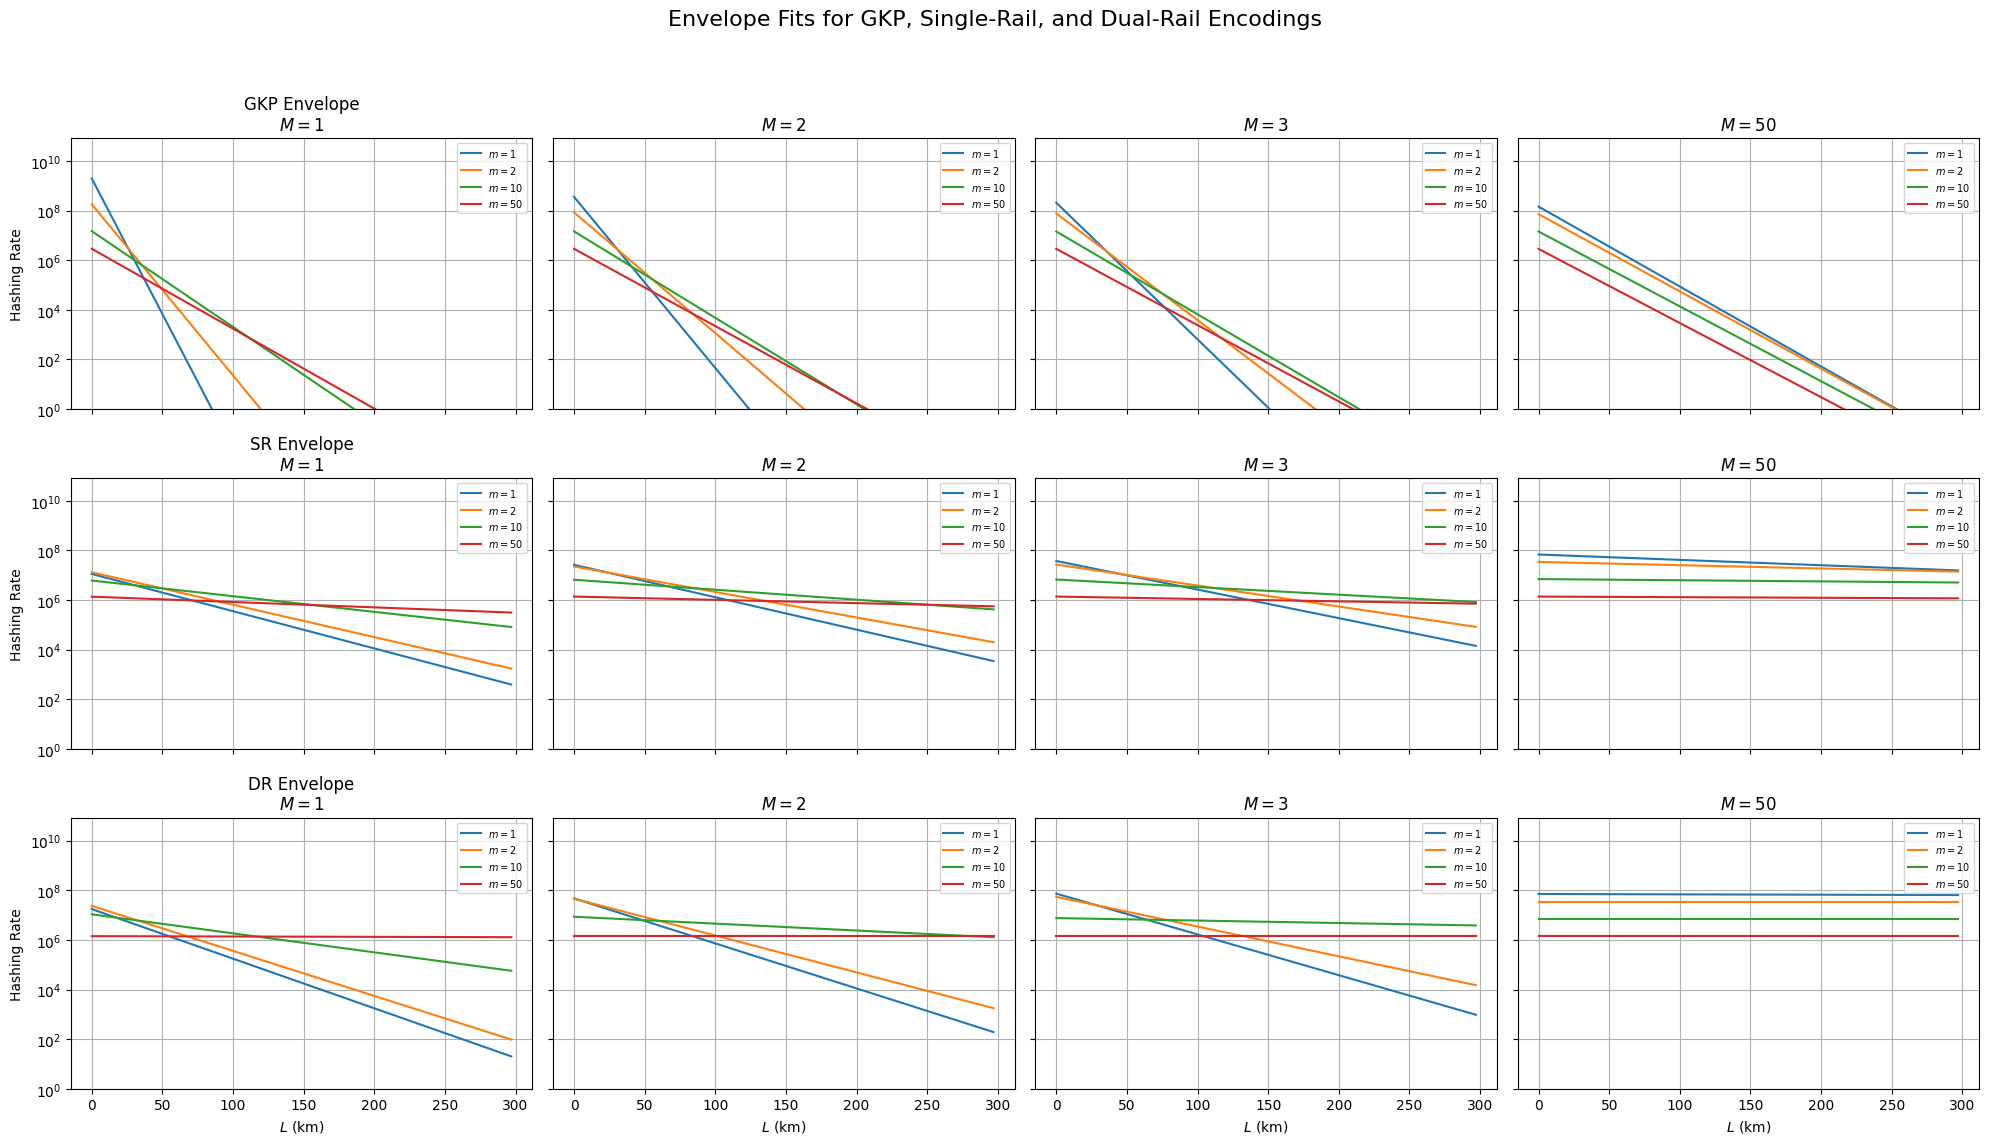

In [20]:
fig, axes = plt.subplots(3, len(M_vals), figsize=(5 * len(M_vals), 12), sharex=True, sharey=True)
encodings = ["GKP", "SR", "DR"]
envelope_data = [gkp_envelope_data, sr_envelope_data, dr_envelope_data]
ylabels = ["Hashing Rate"] + ["" for _ in range(2)]

for row, (label, data) in enumerate(zip(encodings, envelope_data)):
    for col, M in enumerate(M_vals):
        ax = axes[row, col] if len(M_vals) > 1 else axes[row]  # support case where M_vals has 1 element
        envelopes = data[M]

        for m, env in envelopes:
            ax.plot(Ls, env, label=f"$m = {m}$")

        ax.set_yscale("log")
        ax.grid(True)
        ax.set_ylim(bottom=1)
        if row == 2:
            ax.set_xlabel("$L$ (km)")
        if col == 0:
            ax.set_ylabel("Hashing Rate")
            ax.set_title(f"{label} Envelope\n$M = {M}$")
        else:
            ax.set_title(f"$M = {M}$")
        ax.legend(fontsize=7)

fig.suptitle("Envelope Fits for GKP, Single-Rail, and Dual-Rail Encodings", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [21]:
max_m_envelope_data = {}  # Store max over m curves per M

for M in M_vals:
    m_predicted_curves = gkp_envelope_data[M]  # list of (m, predicted_env)
    env_matrix = np.array([curve for (_, curve) in m_predicted_curves])  # shape: (len(m_vals), len(Ls))
    max_env = np.max(env_matrix, axis=0)  # max over m at each L
    max_m_envelope_data[M] = max_env

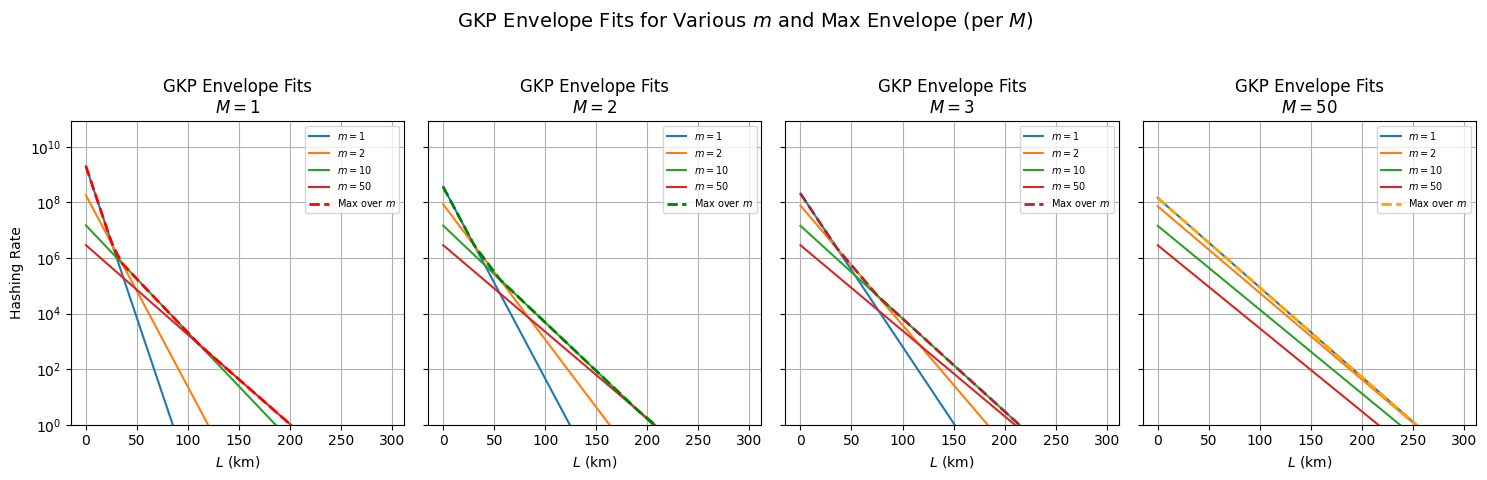

In [22]:
fig, axes = plt.subplots(1, len(M_vals), figsize=(15, 5), sharey=True)
colors = ["red", "green", "brown", "orange", "purple", "black", "blue", "pink"]  # One per M panel

for idx, M in enumerate(M_vals):
    ax = axes[idx]
    m_predicted_curves = gkp_envelope_data[M]

    for m, predicted_env in m_predicted_curves:
        ax.plot(Ls, predicted_env, label=f"$m = {m}$")

    # Overlay max envelope over m
    ax.plot(Ls, max_m_envelope_data[M], "--", color=colors[idx],
            linewidth=2, label=r"Max over $m$")

    ax.set_yscale("log")
    ax.set_xlabel("$L$ (km)")
    ax.set_title(f"GKP Envelope Fits\n$M = {M}$")
    ax.grid(True)
    if idx == 0:
        ax.set_ylabel("Hashing Rate")
    ax.set_ylim(bottom=1)
    ax.legend(fontsize=7)

fig.suptitle("GKP Envelope Fits for Various $m$ and Max Envelope (per $M$)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

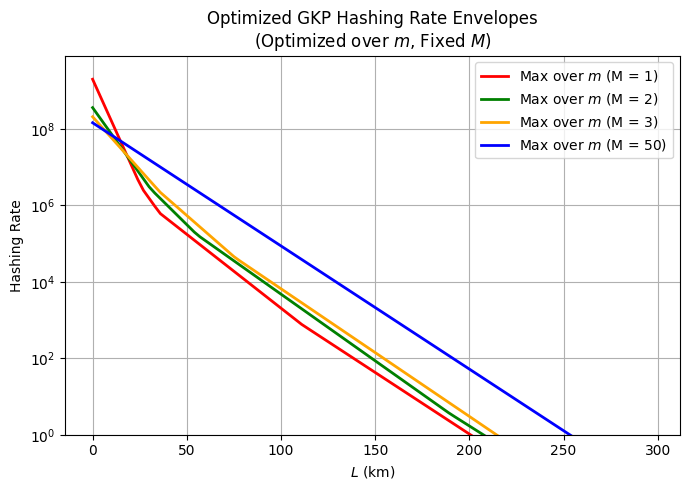

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))

colors = {
    1: "red",
    2: "green",
    3: "orange",
    50: "blue"
}
for M in M_vals:
    envelope = max_m_envelope_data[M]
    ax.plot(Ls, envelope, linewidth=2, color=colors[M], label=fr"Max over $m$ (M = {M})")

ax.set_yscale("log")
ax.set_xlabel("$L$ (km)")
ax.set_ylabel("Hashing Rate")
ax.set_ylim(bottom=1)
ax.set_title("Optimized GKP Hashing Rate Envelopes\n(Optimized over $m$, Fixed $M$)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [24]:
# Store max-over-m envelopes for each encoding
max_m_envelope_data = {
    "GKP": {},
    "SR": {},
    "DR": {}
}

# List of envelope datasets and corresponding labels
envelope_data_list = [
    ("GKP", gkp_envelope_data),
    ("SR", sr_envelope_data),
    ("DR", dr_envelope_data)
]

for label, envelope_data in envelope_data_list:
    for M in M_vals:
        m_predicted_curves = envelope_data[M]  # list of (m, predicted_env)
        env_matrix = np.array([curve for (_, curve) in m_predicted_curves])  # shape: (len(m_vals), len(Ls))
        max_env = np.max(env_matrix, axis=0)  # max over m at each L
        max_m_envelope_data[label][M] = max_env

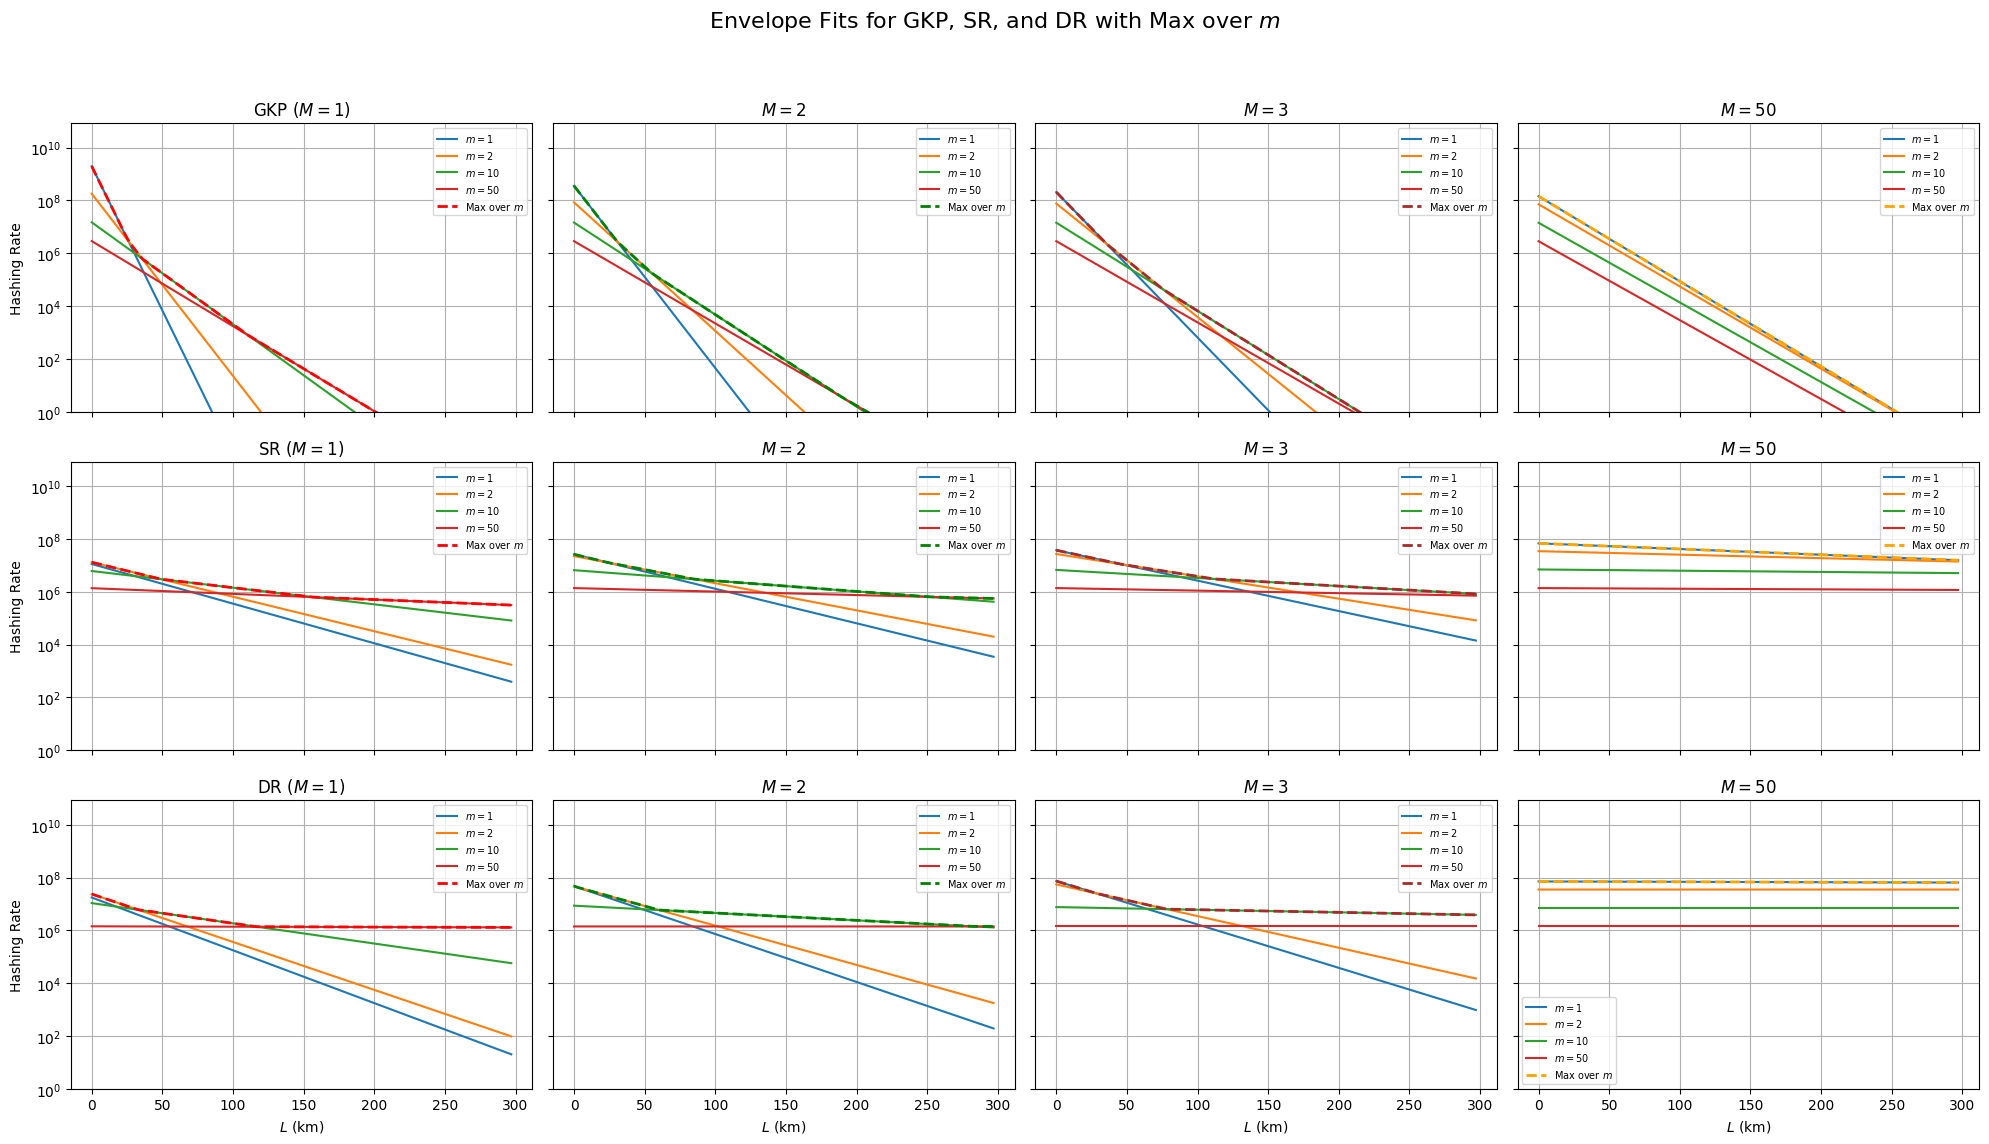

In [25]:
encodings = ["GKP", "SR", "DR"]
envelope_data_list = [gkp_envelope_data, sr_envelope_data, dr_envelope_data]

fig, axes = plt.subplots(3, len(M_vals), figsize=(5 * len(M_vals), 12), sharex=True, sharey=True)
colors = ["red", "green", "brown", "orange", "purple", "black", "blue", "pink"]

for row, (encoding, envelope_data) in enumerate(zip(encodings, envelope_data_list)):
    for col, M in enumerate(M_vals):
        ax = axes[row, col] if len(M_vals) > 1 else axes[row]

        m_predicted_curves = envelope_data[M]  # list of (m, predicted_env)
        env_matrix = np.array([curve for (_, curve) in m_predicted_curves])  # shape: (len(m_vals), len(Ls))
        max_env = np.max(env_matrix, axis=0)

        # Plot individual m curves
        for m, predicted_env in m_predicted_curves:
            ax.plot(Ls, predicted_env, label=f"$m = {m}$")

        # Overlay max envelope over m
        ax.plot(Ls, max_env, "--", color=colors[col % len(colors)], linewidth=2, label=r"Max over $m$")

        ax.set_yscale("log")
        ax.grid(True)
        ax.set_ylim(bottom=1)

        if row == 2:
            ax.set_xlabel("$L$ (km)")
        if col == 0:
            ax.set_ylabel("Hashing Rate")
            ax.set_title(f"{encoding} ($M = {M}$)")
        else:
            ax.set_title(f"$M = {M}$")

        ax.legend(fontsize=7)

fig.suptitle("Envelope Fits for GKP, SR, and DR with Max over $m$", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

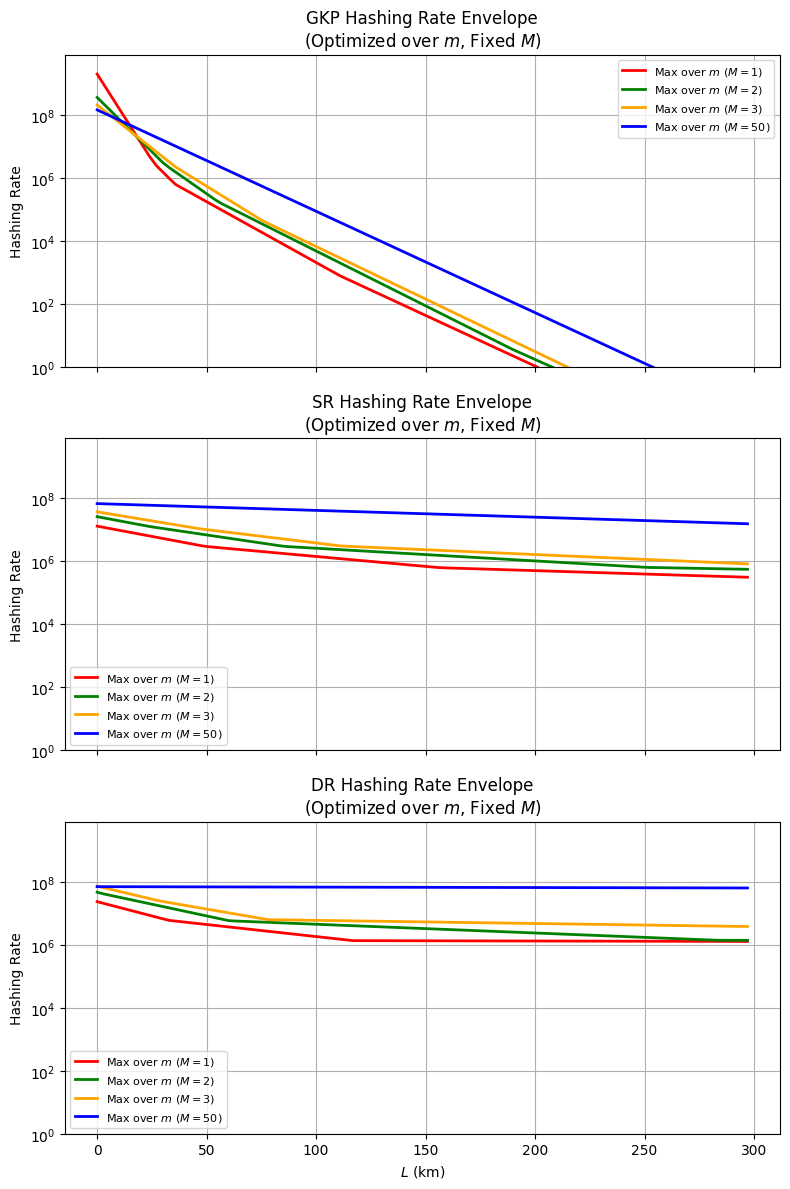

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True, sharey=True)

encoding_labels = ["GKP", "SR", "DR"]
colors = {
    1: "red",
    2: "green",
    3: "orange",
    50: "blue"
}

for idx, encoding in enumerate(encoding_labels):
    ax = axes[idx]
    for M in M_vals:
        envelope = max_m_envelope_data[encoding][M]
        ax.plot(Ls, envelope, linewidth=2, color=colors.get(M, "black"),
                label=fr"Max over $m$ ($M = {M}$)")

    ax.set_yscale("log")
    ax.grid(True)
    ax.set_ylim(bottom=1)
    ax.set_title(f"{encoding} Hashing Rate Envelope\n(Optimized over $m$, Fixed $M$)", fontsize=12)
    if idx == 2:
        ax.set_xlabel("$L$ (km)")
    ax.set_ylabel("Hashing Rate")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

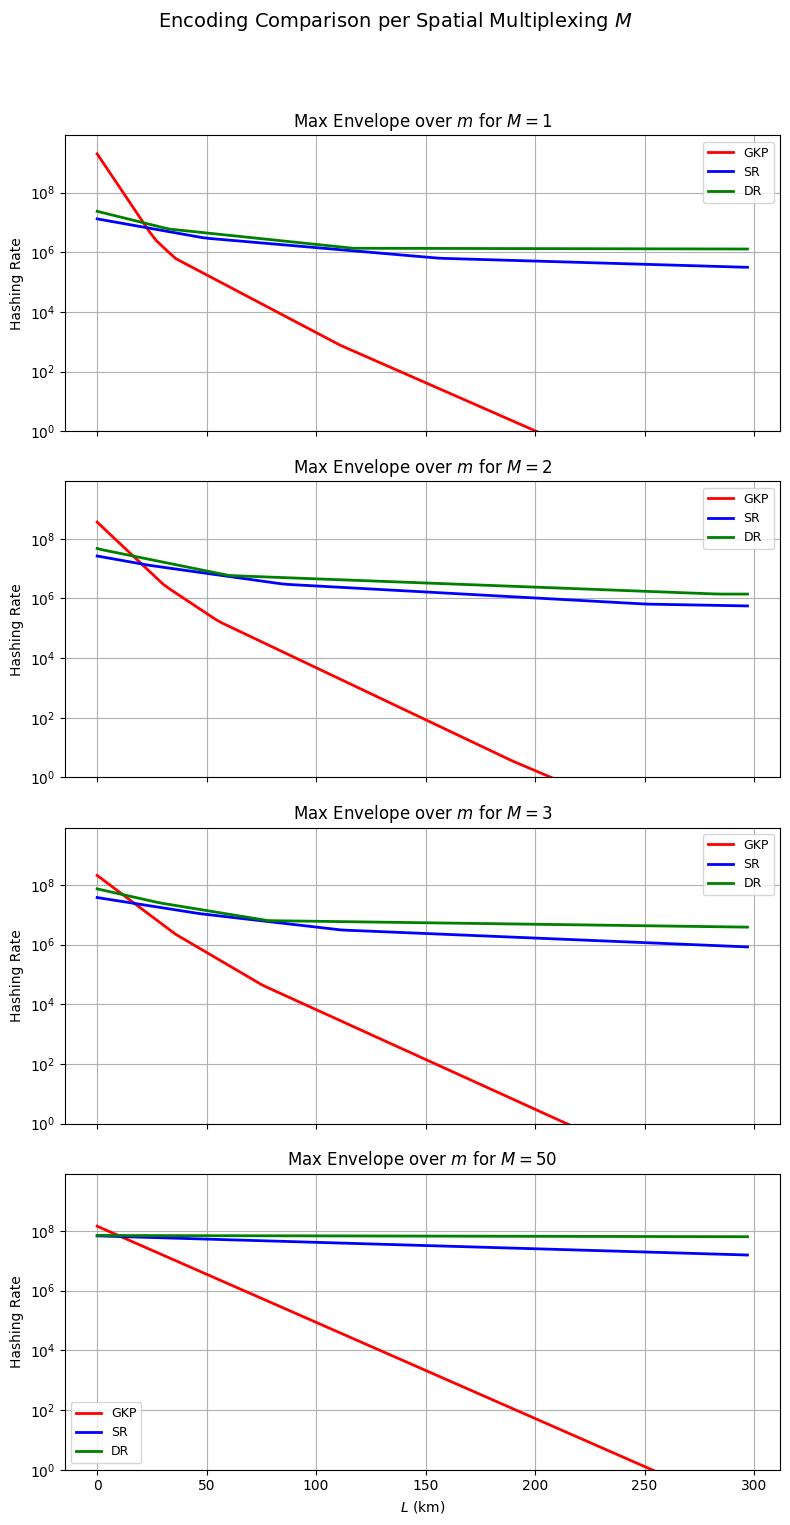

In [30]:
fig, axes = plt.subplots(len(M_vals), 1, figsize=(8, 4 * len(M_vals)), sharex=True, sharey=True)


encoding_labels = ["GKP", "SR", "DR"]
colors = {
    "GKP": "red",
    "SR": "blue",
    "DR": "green"
}

for idx, M in enumerate(M_vals):
    ax = axes[idx] if len(M_vals) > 1 else axes  # support case when len(M_vals) == 1
    for encoding in encoding_labels:
        envelope = max_m_envelope_data[encoding][M]
        ax.plot(Ls, envelope,
                color=colors[encoding], linewidth=2, label=encoding)

    ax.set_yscale("log")
    ax.grid(True)
    ax.set_ylim(bottom=1)
    ax.set_title(f"Max Envelope over $m$ for $M = {M}$", fontsize=12)
    if idx == len(M_vals) - 1:
        ax.set_xlabel("$L$ (km)")
    ax.set_ylabel("Hashing Rate")
    ax.legend(fontsize=9)

plt.suptitle("Encoding Comparison per Spatial Multiplexing $M$", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()